In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

In [3]:
# Write your imports and code here or insert cells below

from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *

In [4]:
#(a)

In [5]:
# Load the data
data = spark.read.csv("hdfs:///data/ghcnd/daily/*.csv.gz")


schema_routes = StructType([
    StructField("ID", StringType(), True),
    StructField("DATE", StringType(), True),
    StructField("ELEMENT", StringType(), True),
    StructField("VALUE", FloatType(), True),
    StructField("MEASUREMENT_FLAG", StringType(), True),
    StructField("QUALITY_FLAG", StringType(), True),
    StructField("SOURCE_FLAG", StringType(), True),
    StructField("OBSERVATION_TIME", TimestampType(), True),
])
daily_new = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema_routes)
    .load("hdfs:///data/ghcnd/daily/*.csv.gz")
)
daily_new.show(10)

# Count the number of rows
count = data.count()

print(f"Number of rows in daily: {count}")


+-----------+--------+-------+-----+----------------+------------+-----------+----------------+
|         ID|    DATE|ELEMENT|VALUE|MEASUREMENT_FLAG|QUALITY_FLAG|SOURCE_FLAG|OBSERVATION_TIME|
+-----------+--------+-------+-----+----------------+------------+-----------+----------------+
|AE000041196|20100101|   TMAX|259.0|            null|        null|          S|            null|
|AE000041196|20100101|   TMIN|120.0|            null|        null|          S|            null|
|AE000041196|20100101|   TAVG|181.0|               H|        null|          S|            null|
|AEM00041194|20100101|   TMAX|250.0|            null|        null|          S|            null|
|AEM00041194|20100101|   TMIN|168.0|            null|        null|          S|            null|
|AEM00041194|20100101|   PRCP|  0.0|            null|        null|          S|            null|
|AEM00041194|20100101|   TAVG|194.0|               H|        null|          S|            null|
|AEM00041217|20100101|   TMAX|250.0|    

In [6]:
daily_new.printSchema()

root
 |-- ID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: float (nullable = true)
 |-- MEASUREMENT_FLAG: string (nullable = true)
 |-- QUALITY_FLAG: string (nullable = true)
 |-- SOURCE_FLAG: string (nullable = true)
 |-- OBSERVATION_TIME: timestamp (nullable = true)



In [ ]:
#(b)

In [7]:
from pyspark.sql.functions import col

# Assuming 'daily_data' is your DataFrame that includes the 'ELEMENT' column
core_elements = ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD']
filtered_daily_df = daily_new.filter(daily_new['ELEMENT'].isin(core_elements))

# Count observations for each core element and order by count in descending order
element_counts = filtered_daily_df.groupBy("ELEMENT").count().orderBy(col("count").desc())

# Display the counts for all core elements
element_counts.show()


+-------+----------+
|ELEMENT|     count|
+-------+----------+
|   PRCP|1069105193|
|   TMAX| 455946095|
|   TMIN| 454759421|
|   SNOW| 353904309|
|   SNWD| 297846434|
+-------+----------+



In [8]:
high_observed_element = element_counts.orderBy('count', ascending=False).first()
print("Highly Observed Element: ", high_observed_element['ELEMENT'])

Highly Observed Element:  PRCP


In [ ]:
#(c)

In [ ]:
# filter observation for TMIN and TMAX

In [9]:
from pyspark.sql.functions import count, when

# Filter TMIN and TMAX data
tmin_tmax_df = daily_new.filter((daily_new["ELEMENT"] == "TMIN") | (daily_new["ELEMENT"] == "TMAX"))


In [10]:
# make new data frame
new_df = tmin_tmax_df.groupBy(
    "ID", "DATE").agg(
    count(when(tmin_tmax_df["ELEMENT"] == "TMIN", True)).alias("TMIN_NO"), 
    count(when(tmin_tmax_df["ELEMENT"] == "TMAX", True)).alias("TMAX_NO"))


In [11]:
show_as_html(new_df,10)

ID      DATE  TMIN_NO  TMAX_NO
0  ASN00004106  20090101        1        1
1  ASN00005094  20090101        1        1
2  ASN00008290  20090101        1        1
3  ASN00009965  20090101        1        1
4  ASN00014277  20090101        1        1
5  ASN00014609  20090101        1        1
6  ASN00029058  20090101        1        1
7  ASN00039104  20090101        1        1
8  ASN00040068  20090101        1        1
9  ASN00040284  20090101        1        1

In [ ]:
# Find stations with missing TMAX observations

In [12]:
missing_tmax_number = new_df.filter((new_df["TMIN_NO"] > 0) & (new_df["TMAX_NO"] == 0))

# Count observations with missing TMAX
missing_tmax_count = missing_tmax_number.count()

print(f"Number of observations with missing TMAX: {missing_tmax_count}")

Number of observations with missing TMAX: 9322723


In [ ]:
# Count Unique Stations

In [13]:
from pyspark.sql.functions import countDistinct

# Assuming missing_tmax_number contains the rows where TMIN is reported but TMAX is not

# Count unique stations with missing TMAX observations
unique_stations_with_missing_tmax = missing_tmax_number.agg(countDistinct("ID").alias("UNIQUE_STATIONS_COUNT"))

# Collect the result as a number
unique_stations_count = unique_stations_with_missing_tmax.collect()[0]["UNIQUE_STATIONS_COUNT"]

# Print the count of unique stations
print(f"Number of unique stations with missing TMAX observations: {unique_stations_count}")



Number of unique stations with missing TMAX observations: 27927


In [14]:
unique_stations_with_missing_tmax.show()

+---------------------+
|UNIQUE_STATIONS_COUNT|
+---------------------+
|                27927|
+---------------------+



In [ ]:
#(d)

In [ ]:
# Filter Observations for New Zealand Stations

In [15]:
enr_stations_df = spark.read.parquet("/user/cgo82/outputs/enriched_stations.parquet")
enr_stations_df.printSchema()
show_as_html(enr_stations_df,10)

root
 |-- ID: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- GSN_FLAG: string (nullable = true)
 |-- HCN_CRN_FLAG: string (nullable = true)
 |-- WMO_ID: string (nullable = true)
 |-- COUNTRY_CODE: string (nullable = true)
 |-- CODE: string (nullable = true)
 |-- COUNTRY_NAME: string (nullable = true)
 |-- STATE_CODE: string (nullable = true)
 |-- STATE_NAME: string (nullable = true)
 |-- FIRST_ACTIVE_YEAR: string (nullable = true)
 |-- LAST_ACTIVE_YEAR: string (nullable = true)
 |-- NUM_ELEMENTS: long (nullable = true)
 |-- CORE_ELEMENT_CT: long (nullable = true)
 |-- OTHER_ELEMENT_CT: long (nullable = true)
 |-- COLLECTED_ELEMENTS: array (nullable = true)
 |    |-- element: string (containsNull = true)



ID  LATITUDE  LONGITUDE ELEVATION                            NAME  \
0  AFM00040990   31.5000    65.8500    1010.0  KANDAHAR AIRPORT                 
1  AGE00147718   34.8500     5.7200     125.0  BISKRA                           
2  AGM00060417   36.3830     3.8830     560.0  BOUIRA                           
3  AGM00060421   35.8670     7.1170     891.0  OUM EL BOUAGHI                   
4  AGM00060531   35.0170    -1.4500     248.1  ZENATA                           
5  AJ000037895   39.9830    46.7500     828.0  KHANKANDY                        
6  AM000037782   40.4000    44.3000    1893.0  AMBERD (KOSHABULAKH)             
7  AM000037791   40.4000    44.6830    1800.0  FANTAN                           
8  AO000066447  -15.8330    20.3500    1088.0  MAVINGA                          
9  AR000087828  -43.2000   -65.2660      43.0  TRELEW AERO                      

  GSN_FLAG HCN_CRN_FLAG WMO_ID COUNTRY_CODE CODE COUNTRY_NAME STATE_CODE  \
0                        40990           AF   AF  Afghanistan       None   
1                        60525           AG   AG     Algeria        None   
2                        60417           AG   AG     Algeria        None   
3                        60421           AG   AG     Algeria        None   
4                        60531           AG   AG     Algeria        None   
5                        37895           AJ   AJ  Azerbaijan        None   
6                        37782           AM   AM     Armenia        None   
7                        37791           AM   AM     Armenia        None   
8      GSN               66447           AO   AO      Angola        None   
9      GSN               87828           AR   AR   Argentina        None   

  STATE_NAME FIRST_ACTIVE_YEAR LAST_ACTIVE_YEAR  NUM_ELEMENTS  \
0       None              1973             2020             5   
1       None              1880             2024             4   
2       None              1995             2024             5   
3       None              1985             2024             5   
4       None              1981             2024             5   
5       None              1936             1991             5   
6       None              1919             1992             1   
7       None              1936             1992             5   
8       None              1957             1975             4   
9       None              1956             2024             5   

   CORE_ELEMENT_CT  OTHER_ELEMENT_CT              COLLECTED_ELEMENTS  
0                4               1.0  [TMAX, TMIN, PRCP, SNWD, TAVG]  
1                3               1.0        [TMAX, TMIN, PRCP, TAVG]  
2                4               1.0  [TMAX, TMIN, PRCP, SNWD, TAVG]  
3                4               1.0  [TMAX, TMIN, PRCP, SNWD, TAVG]  
4                4               1.0  [TMAX, TMIN, PRCP, SNWD, TAVG]  
5                4               1.0  [TMAX, TMIN, PRCP, SNWD, TAVG]  
6                1               NaN                          [PRCP]  
7                4               1.0  [TMAX, TMIN, PRCP, SNWD, TAVG]  
8                3               1.0        [TMAX, TMIN, PRCP, TAVG]  
9                4               1.0  [TMAX, TMIN, PRCP, SNWD, TAVG]

In [16]:
complete_df= daily_new.join(enr_stations_df,
                                    on="ID",
                                    how="left")
show_as_html(complete_df,10)

ID      DATE ELEMENT  VALUE MEASUREMENT_FLAG QUALITY_FLAG  \
0  AE000041196  20100101    TMAX  259.0             None         None   
1  AE000041196  20100101    TMIN  120.0             None         None   
2  AE000041196  20100101    TAVG  181.0                H         None   
3  AEM00041194  20100101    TMAX  250.0             None         None   
4  AEM00041194  20100101    TMIN  168.0             None         None   
5  AEM00041194  20100101    PRCP    0.0             None         None   
6  AEM00041194  20100101    TAVG  194.0                H         None   
7  AEM00041217  20100101    TMAX  250.0             None         None   
8  AEM00041217  20100101    TMIN  146.0             None         None   
9  AEM00041217  20100101    TAVG  199.0                H         None   

  SOURCE_FLAG OBSERVATION_TIME  LATITUDE  LONGITUDE            ...             \
0           S              NaT   25.3330    55.5170            ...              
1           S              NaT   25.3330    55.5170            ...              
2           S              NaT   25.3330    55.5170            ...              
3           S              NaT   25.2550    55.3640            ...              
4           S              NaT   25.2550    55.3640            ...              
5           S              NaT   25.2550    55.3640            ...              
6           S              NaT   25.2550    55.3640            ...              
7           S              NaT   24.4330    54.6510            ...              
8           S              NaT   24.4330    54.6510            ...              
9           S              NaT   24.4330    54.6510            ...              

  CODE           COUNTRY_NAME STATE_CODE STATE_NAME FIRST_ACTIVE_YEAR  \
0   AE  United Arab Emirates        None       None              1944   
1   AE  United Arab Emirates        None       None              1944   
2   AE  United Arab Emirates        None       None              1944   
3   AE  United Arab Emirates        None       None              1983   
4   AE  United Arab Emirates        None       None              1983   
5   AE  United Arab Emirates        None       None              1983   
6   AE  United Arab Emirates        None       None              1983   
7   AE  United Arab Emirates        None       None              1983   
8   AE  United Arab Emirates        None       None              1983   
9   AE  United Arab Emirates        None       None              1983   

  LAST_ACTIVE_YEAR NUM_ELEMENTS CORE_ELEMENT_CT OTHER_ELEMENT_CT  \
0             2024            4               3                1   
1             2024            4               3                1   
2             2024            4               3                1   
3             2024            4               3                1   
4             2024            4               3                1   
5             2024            4               3                1   
6             2024            4               3                1   
7             2024            4               3                1   
8             2024            4               3                1   
9             2024            4               3                1   

         COLLECTED_ELEMENTS  
0  [TMAX, TMIN, PRCP, TAVG]  
1  [TMAX, TMIN, PRCP, TAVG]  
2  [TMAX, TMIN, PRCP, TAVG]  
3  [TMAX, TMIN, PRCP, TAVG]  
4  [TMAX, TMIN, PRCP, TAVG]  
5  [TMAX, TMIN, PRCP, TAVG]  
6  [TMAX, TMIN, PRCP, TAVG]  
7  [TMAX, TMIN, PRCP, TAVG]  
8  [TMAX, TMIN, PRCP, TAVG]  
9  [TMAX, TMIN, PRCP, TAVG]  

[10 rows x 26 columns]

In [17]:
complete_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: float (nullable = true)
 |-- MEASUREMENT_FLAG: string (nullable = true)
 |-- QUALITY_FLAG: string (nullable = true)
 |-- SOURCE_FLAG: string (nullable = true)
 |-- OBSERVATION_TIME: timestamp (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- GSN_FLAG: string (nullable = true)
 |-- HCN_CRN_FLAG: string (nullable = true)
 |-- WMO_ID: string (nullable = true)
 |-- COUNTRY_CODE: string (nullable = true)
 |-- CODE: string (nullable = true)
 |-- COUNTRY_NAME: string (nullable = true)
 |-- STATE_CODE: string (nullable = true)
 |-- STATE_NAME: string (nullable = true)
 |-- FIRST_ACTIVE_YEAR: string (nullable = true)
 |-- LAST_ACTIVE_YEAR: string (nullable = true)
 |-- NUM_ELEMENTS: long (nullable = true)
 |-- CORE_ELEMENT_CT: long (nullable 

In [18]:
# Filter data for TMIN and TMAX observations
tmin_tmax_df = complete_df.filter((col("ELEMENT") == "TMIN") | (col("ELEMENT") == "TMAX"))


In [19]:
tmin_tmax_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: float (nullable = true)
 |-- MEASUREMENT_FLAG: string (nullable = true)
 |-- QUALITY_FLAG: string (nullable = true)
 |-- SOURCE_FLAG: string (nullable = true)
 |-- OBSERVATION_TIME: timestamp (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- GSN_FLAG: string (nullable = true)
 |-- HCN_CRN_FLAG: string (nullable = true)
 |-- WMO_ID: string (nullable = true)
 |-- COUNTRY_CODE: string (nullable = true)
 |-- CODE: string (nullable = true)
 |-- COUNTRY_NAME: string (nullable = true)
 |-- STATE_CODE: string (nullable = true)
 |-- STATE_NAME: string (nullable = true)
 |-- FIRST_ACTIVE_YEAR: string (nullable = true)
 |-- LAST_ACTIVE_YEAR: string (nullable = true)
 |-- NUM_ELEMENTS: long (nullable = true)
 |-- CORE_ELEMENT_CT: long (nullable 

In [ ]:
#filter new zealand stations

In [20]:
whole_nz_stations = tmin_tmax_df.filter(tmin_tmax_df["Country_Name"].contains("New Zealand"))
show_as_html(whole_nz_stations ,10)

ID      DATE ELEMENT  VALUE MEASUREMENT_FLAG QUALITY_FLAG  \
0  CWM00091843  20100101    TMIN  228.0             None         None   
1  NZ000093292  20100101    TMAX  297.0             None         None   
2  NZ000093292  20100101    TMIN   74.0             None         None   
3  NZ000093417  20100101    TMAX  180.0             None         None   
4  NZ000093417  20100101    TMIN  125.0             None         None   
5  NZ000093844  20100101    TMAX  232.0             None         None   
6  NZ000093844  20100101    TMIN   96.0             None         None   
7  NZ000933090  20100101    TMAX  197.0             None         None   
8  NZ000933090  20100101    TMIN   82.0             None         None   
9  NZ000936150  20100101    TMAX  324.0             None         None   

  SOURCE_FLAG OBSERVATION_TIME  LATITUDE  LONGITUDE            ...             \
0           S              NaT  -21.2030  -159.8060            ...              
1           S              NaT  -38.6500   177.9830            ...              
2           S              NaT  -38.6500   177.9830            ...              
3           S              NaT  -40.9000   174.9830            ...              
4           S              NaT  -40.9000   174.9830            ...              
5           S              NaT  -46.4170   168.3330            ...              
6           S              NaT  -46.4170   168.3330            ...              
7           S              NaT  -39.0170   174.1830            ...              
8           S              NaT  -39.0170   174.1830            ...              
9           S              NaT  -42.7170   170.9830            ...              

  CODE                COUNTRY_NAME STATE_CODE STATE_NAME FIRST_ACTIVE_YEAR  \
0   CW  Cook Islands [New Zealand]       None       None              1973   
1   NZ                New Zealand        None       None              1962   
2   NZ                New Zealand        None       None              1962   
3   NZ                New Zealand        None       None              1972   
4   NZ                New Zealand        None       None              1972   
5   NZ                New Zealand        None       None              1948   
6   NZ                New Zealand        None       None              1948   
7   NZ                New Zealand        None       None              1944   
8   NZ                New Zealand        None       None              1944   
9   NZ                New Zealand        None       None              1964   

  LAST_ACTIVE_YEAR NUM_ELEMENTS CORE_ELEMENT_CT OTHER_ELEMENT_CT  \
0             2024            4               3                1   
1             2024            4               3                1   
2             2024            4               3                1   
3             2024            4               3                1   
4             2024            4               3                1   
5             2024            4               3                1   
6             2024            4               3                1   
7             2024            4               3                1   
8             2024            4               3                1   
9             2024            4               3                1   

         COLLECTED_ELEMENTS  
0  [TMAX, TMIN, PRCP, TAVG]  
1  [TMAX, TMIN, PRCP, TAVG]  
2  [TMAX, TMIN, PRCP, TAVG]  
3  [TMAX, TMIN, PRCP, TAVG]  
4  [TMAX, TMIN, PRCP, TAVG]  
5  [TMAX, TMIN, PRCP, TAVG]  
6  [TMAX, TMIN, PRCP, TAVG]  
7  [TMAX, TMIN, PRCP, TAVG]  
8  [TMAX, TMIN, PRCP, TAVG]  
9  [TMAX, TMIN, PRCP, TAVG]  

[10 rows x 26 columns]

In [21]:
# Filter for stations in New Zealand 
tmin_tmax_nz = tmin_tmax_df.filter(tmin_tmax_df["CODE"].contains("NZ"))
show_as_html(tmin_tmax_nz  ,10)

ID      DATE ELEMENT  VALUE MEASUREMENT_FLAG QUALITY_FLAG  \
0  NZ000093292  20100101    TMAX  297.0             None         None   
1  NZ000093292  20100101    TMIN   74.0             None         None   
2  NZ000093417  20100101    TMAX  180.0             None         None   
3  NZ000093417  20100101    TMIN  125.0             None         None   
4  NZ000093844  20100101    TMAX  232.0             None         None   
5  NZ000093844  20100101    TMIN   96.0             None         None   
6  NZ000933090  20100101    TMAX  197.0             None         None   
7  NZ000933090  20100101    TMIN   82.0             None         None   
8  NZ000936150  20100101    TMAX  324.0             None         None   
9  NZM00093110  20100101    TMAX  215.0             None         None   

  SOURCE_FLAG OBSERVATION_TIME  LATITUDE  LONGITUDE            ...             \
0           S              NaT  -38.6500   177.9830            ...              
1           S              NaT  -38.6500   177.9830            ...              
2           S              NaT  -40.9000   174.9830            ...              
3           S              NaT  -40.9000   174.9830            ...              
4           S              NaT  -46.4170   168.3330            ...              
5           S              NaT  -46.4170   168.3330            ...              
6           S              NaT  -39.0170   174.1830            ...              
7           S              NaT  -39.0170   174.1830            ...              
8           S              NaT  -42.7170   170.9830            ...              
9           S              NaT  -37.0000   174.8000            ...              

  CODE  COUNTRY_NAME STATE_CODE STATE_NAME FIRST_ACTIVE_YEAR LAST_ACTIVE_YEAR  \
0   NZ  New Zealand        None       None              1962             2024   
1   NZ  New Zealand        None       None              1962             2024   
2   NZ  New Zealand        None       None              1972             2024   
3   NZ  New Zealand        None       None              1972             2024   
4   NZ  New Zealand        None       None              1948             2024   
5   NZ  New Zealand        None       None              1948             2024   
6   NZ  New Zealand        None       None              1944             2024   
7   NZ  New Zealand        None       None              1944             2024   
8   NZ  New Zealand        None       None              1964             2024   
9   NZ  New Zealand        None       None              1994             2024   

  NUM_ELEMENTS CORE_ELEMENT_CT OTHER_ELEMENT_CT        COLLECTED_ELEMENTS  
0            4               3                1  [TMAX, TMIN, PRCP, TAVG]  
1            4               3                1  [TMAX, TMIN, PRCP, TAVG]  
2            4               3                1  [TMAX, TMIN, PRCP, TAVG]  
3            4               3                1  [TMAX, TMIN, PRCP, TAVG]  
4            4               3                1  [TMAX, TMIN, PRCP, TAVG]  
5            4               3                1  [TMAX, TMIN, PRCP, TAVG]  
6            4               3                1  [TMAX, TMIN, PRCP, TAVG]  
7            4               3                1  [TMAX, TMIN, PRCP, TAVG]  
8            4               3                1  [TMAX, TMIN, PRCP, TAVG]  
9            4               3                1  [TMAX, TMIN, PRCP, TAVG]  

[10 rows x 26 columns]

In [23]:
tmin_tmax_nz.printSchema()

root
 |-- ID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: float (nullable = true)
 |-- MEASUREMENT_FLAG: string (nullable = true)
 |-- QUALITY_FLAG: string (nullable = true)
 |-- SOURCE_FLAG: string (nullable = true)
 |-- OBSERVATION_TIME: timestamp (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- GSN_FLAG: string (nullable = true)
 |-- HCN_CRN_FLAG: string (nullable = true)
 |-- WMO_ID: string (nullable = true)
 |-- COUNTRY_CODE: string (nullable = true)
 |-- CODE: string (nullable = true)
 |-- COUNTRY_NAME: string (nullable = true)
 |-- STATE_CODE: string (nullable = true)
 |-- STATE_NAME: string (nullable = true)
 |-- FIRST_ACTIVE_YEAR: string (nullable = true)
 |-- LAST_ACTIVE_YEAR: string (nullable = true)
 |-- NUM_ELEMENTS: long (nullable = true)
 |-- CORE_ELEMENT_CT: long (nullable 

In [24]:
tmin_tmax_df.show()

+-----------+--------+-------+-----+----------------+------------+-----------+----------------+--------+---------+---------+--------------------+--------+------------+------+------------+----+--------------------+----------+----------+-----------------+----------------+------------+---------------+----------------+--------------------+
|         ID|    DATE|ELEMENT|VALUE|MEASUREMENT_FLAG|QUALITY_FLAG|SOURCE_FLAG|OBSERVATION_TIME|LATITUDE|LONGITUDE|ELEVATION|                NAME|GSN_FLAG|HCN_CRN_FLAG|WMO_ID|COUNTRY_CODE|CODE|        COUNTRY_NAME|STATE_CODE|STATE_NAME|FIRST_ACTIVE_YEAR|LAST_ACTIVE_YEAR|NUM_ELEMENTS|CORE_ELEMENT_CT|OTHER_ELEMENT_CT|  COLLECTED_ELEMENTS|
+-----------+--------+-------+-----+----------------+------------+-----------+----------------+--------+---------+---------+--------------------+--------+------------+------+------------+----+--------------------+----------+----------+-----------------+----------------+------------+---------------+----------------+--------

In [25]:
output_dir = "hdfs:///user/cgo82/outputs/ghcnd/tmin_tmax_nz.parquet"
tmin_tmax_nz.write.mode("overwrite").parquet(output_dir)


In [26]:
nz_station_data = spark.read.parquet("/user/cgo82/outputs/ghcnd/tmin_tmax_nz.parquet")

In [27]:
nz_station_data.printSchema()

root
 |-- ID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: float (nullable = true)
 |-- MEASUREMENT_FLAG: string (nullable = true)
 |-- QUALITY_FLAG: string (nullable = true)
 |-- SOURCE_FLAG: string (nullable = true)
 |-- OBSERVATION_TIME: timestamp (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- GSN_FLAG: string (nullable = true)
 |-- HCN_CRN_FLAG: string (nullable = true)
 |-- WMO_ID: string (nullable = true)
 |-- COUNTRY_CODE: string (nullable = true)
 |-- CODE: string (nullable = true)
 |-- COUNTRY_NAME: string (nullable = true)
 |-- STATE_CODE: string (nullable = true)
 |-- STATE_NAME: string (nullable = true)
 |-- FIRST_ACTIVE_YEAR: string (nullable = true)
 |-- LAST_ACTIVE_YEAR: string (nullable = true)
 |-- NUM_ELEMENTS: long (nullable = true)
 |-- CORE_ELEMENT_CT: long (nullable 

In [ ]:
# count the total number of new zealand observations

In [28]:
total_nz_obs = nz_station_data.count()
print(f"Total number of observations for New Zealand: {total_nz_obs}")

Total number of observations for New Zealand: 485520


In [ ]:
#Find the range of year cover

In [29]:
# Display the first few rows to check the actual content of the DATE column
nz_station_data.select("DATE").show(5)

+--------+
|    DATE|
+--------+
|20040101|
|20040101|
|20040101|
|20040101|
|20040101|
+--------+
only showing top 5 rows



In [30]:
from pyspark.sql.functions import to_date

# Since dates are in the format 'yyyyMMdd', should adjust the format string
nz_station_data = nz_station_data.withColumn("DATE", to_date(col("DATE"), "yyyyMMdd"))


In [31]:
nz_station_data.show(5)

+-----------+----------+-------+-----+----------------+------------+-----------+----------------+--------+---------+---------+--------------------+--------+------------+------+------------+----+------------+----------+----------+-----------------+----------------+------------+---------------+----------------+--------------------+
|         ID|      DATE|ELEMENT|VALUE|MEASUREMENT_FLAG|QUALITY_FLAG|SOURCE_FLAG|OBSERVATION_TIME|LATITUDE|LONGITUDE|ELEVATION|                NAME|GSN_FLAG|HCN_CRN_FLAG|WMO_ID|COUNTRY_CODE|CODE|COUNTRY_NAME|STATE_CODE|STATE_NAME|FIRST_ACTIVE_YEAR|LAST_ACTIVE_YEAR|NUM_ELEMENTS|CORE_ELEMENT_CT|OTHER_ELEMENT_CT|  COLLECTED_ELEMENTS|
+-----------+----------+-------+-----+----------------+------------+-----------+----------------+--------+---------+---------+--------------------+--------+------------+------+------------+----+------------+----------+----------+-----------------+----------------+------------+---------------+----------------+--------------------+
|NZ0

In [32]:
nz_station_data.printSchema()

root
 |-- ID: string (nullable = true)
 |-- DATE: date (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: float (nullable = true)
 |-- MEASUREMENT_FLAG: string (nullable = true)
 |-- QUALITY_FLAG: string (nullable = true)
 |-- SOURCE_FLAG: string (nullable = true)
 |-- OBSERVATION_TIME: timestamp (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- GSN_FLAG: string (nullable = true)
 |-- HCN_CRN_FLAG: string (nullable = true)
 |-- WMO_ID: string (nullable = true)
 |-- COUNTRY_CODE: string (nullable = true)
 |-- CODE: string (nullable = true)
 |-- COUNTRY_NAME: string (nullable = true)
 |-- STATE_CODE: string (nullable = true)
 |-- STATE_NAME: string (nullable = true)
 |-- FIRST_ACTIVE_YEAR: string (nullable = true)
 |-- LAST_ACTIVE_YEAR: string (nullable = true)
 |-- NUM_ELEMENTS: long (nullable = true)
 |-- CORE_ELEMENT_CT: long (nullable = 

In [33]:
from pyspark.sql.functions import year, min, max

# Extract year from each date and find the minimum and maximum year
nz_data = nz_station_data.withColumn(
    "YEAR", year("DATE")).agg(
    min("YEAR").alias("Min_Year"), max(
        "YEAR").alias("Max_Year"))

# Display the result
nz_data.show()


+--------+--------+
|Min_Year|Max_Year|
+--------+--------+
|    1940|    2024|
+--------+--------+



In [34]:
!hdfs dfs -copyToLocal hdfs:///user/cgo82/outputs/ghcnd/tmin_tmax_nz.parquet

copyToLocal: `tmin_tmax_nz.parquet/_SUCCESS': File exists


In [35]:
!wc -l ~/tmin_tmax_nz.parquet/part-*

      95 /users/home/cgo82/tmin_tmax_nz.parquet/part-00000-3cbb3262-babc-4f7b-8709-4546e5a86399-c000.snappy.parquet
      95 /users/home/cgo82/tmin_tmax_nz.parquet/part-00000-4ac1628a-1e49-4307-8f13-fb144dfac8ab-c000.snappy.parquet
      95 /users/home/cgo82/tmin_tmax_nz.parquet/part-00000-52f36769-988e-4952-a7d6-835c974b24dd-c000.snappy.parquet
      95 /users/home/cgo82/tmin_tmax_nz.parquet/part-00000-edee96e1-4434-4f14-8c32-c832ce1f3786-c000.snappy.parquet
      95 /users/home/cgo82/tmin_tmax_nz.parquet/part-00000-f09e6aaa-3c69-41cd-aed5-7cd8fa253f55-c000.snappy.parquet
      79 /users/home/cgo82/tmin_tmax_nz.parquet/part-00001-3cbb3262-babc-4f7b-8709-4546e5a86399-c000.snappy.parquet
      79 /users/home/cgo82/tmin_tmax_nz.parquet/part-00001-4ac1628a-1e49-4307-8f13-fb144dfac8ab-c000.snappy.parquet
      79 /users/home/cgo82/tmin_tmax_nz.parquet/part-00001-52f36769-988e-4952-a7d6-835c974b24dd-c000.snappy.parquet
      79 /users/home/cgo82/tmin_tmax_nz.parquet/part-00001-edee96e1-4434

      96 /users/home/cgo82/tmin_tmax_nz.parquet/part-00014-4ac1628a-1e49-4307-8f13-fb144dfac8ab-c000.snappy.parquet
      96 /users/home/cgo82/tmin_tmax_nz.parquet/part-00014-52f36769-988e-4952-a7d6-835c974b24dd-c000.snappy.parquet
      96 /users/home/cgo82/tmin_tmax_nz.parquet/part-00014-edee96e1-4434-4f14-8c32-c832ce1f3786-c000.snappy.parquet
      96 /users/home/cgo82/tmin_tmax_nz.parquet/part-00014-f09e6aaa-3c69-41cd-aed5-7cd8fa253f55-c000.snappy.parquet
      72 /users/home/cgo82/tmin_tmax_nz.parquet/part-00015-3cbb3262-babc-4f7b-8709-4546e5a86399-c000.snappy.parquet
      72 /users/home/cgo82/tmin_tmax_nz.parquet/part-00015-4ac1628a-1e49-4307-8f13-fb144dfac8ab-c000.snappy.parquet
      72 /users/home/cgo82/tmin_tmax_nz.parquet/part-00015-52f36769-988e-4952-a7d6-835c974b24dd-c000.snappy.parquet
      72 /users/home/cgo82/tmin_tmax_nz.parquet/part-00015-edee96e1-4434-4f14-8c32-c832ce1f3786-c000.snappy.parquet
      72 /users/home/cgo82/tmin_tmax_nz.parquet/part-00015-f09e6aaa-3c69

     203 /users/home/cgo82/tmin_tmax_nz.parquet/part-00028-52f36769-988e-4952-a7d6-835c974b24dd-c000.snappy.parquet
     203 /users/home/cgo82/tmin_tmax_nz.parquet/part-00028-edee96e1-4434-4f14-8c32-c832ce1f3786-c000.snappy.parquet
     203 /users/home/cgo82/tmin_tmax_nz.parquet/part-00028-f09e6aaa-3c69-41cd-aed5-7cd8fa253f55-c000.snappy.parquet
     149 /users/home/cgo82/tmin_tmax_nz.parquet/part-00029-3cbb3262-babc-4f7b-8709-4546e5a86399-c000.snappy.parquet
     149 /users/home/cgo82/tmin_tmax_nz.parquet/part-00029-4ac1628a-1e49-4307-8f13-fb144dfac8ab-c000.snappy.parquet
     149 /users/home/cgo82/tmin_tmax_nz.parquet/part-00029-52f36769-988e-4952-a7d6-835c974b24dd-c000.snappy.parquet
     149 /users/home/cgo82/tmin_tmax_nz.parquet/part-00029-edee96e1-4434-4f14-8c32-c832ce1f3786-c000.snappy.parquet
     149 /users/home/cgo82/tmin_tmax_nz.parquet/part-00029-f09e6aaa-3c69-41cd-aed5-7cd8fa253f55-c000.snappy.parquet
     208 /users/home/cgo82/tmin_tmax_nz.parquet/part-00030-3cbb3262-babc

      65 /users/home/cgo82/tmin_tmax_nz.parquet/part-00043-3cbb3262-babc-4f7b-8709-4546e5a86399-c000.snappy.parquet
      65 /users/home/cgo82/tmin_tmax_nz.parquet/part-00043-4ac1628a-1e49-4307-8f13-fb144dfac8ab-c000.snappy.parquet
      65 /users/home/cgo82/tmin_tmax_nz.parquet/part-00043-52f36769-988e-4952-a7d6-835c974b24dd-c000.snappy.parquet
      65 /users/home/cgo82/tmin_tmax_nz.parquet/part-00043-edee96e1-4434-4f14-8c32-c832ce1f3786-c000.snappy.parquet
      65 /users/home/cgo82/tmin_tmax_nz.parquet/part-00043-f09e6aaa-3c69-41cd-aed5-7cd8fa253f55-c000.snappy.parquet
     289 /users/home/cgo82/tmin_tmax_nz.parquet/part-00044-3cbb3262-babc-4f7b-8709-4546e5a86399-c000.snappy.parquet
     289 /users/home/cgo82/tmin_tmax_nz.parquet/part-00044-4ac1628a-1e49-4307-8f13-fb144dfac8ab-c000.snappy.parquet
     289 /users/home/cgo82/tmin_tmax_nz.parquet/part-00044-52f36769-988e-4952-a7d6-835c974b24dd-c000.snappy.parquet
     289 /users/home/cgo82/tmin_tmax_nz.parquet/part-00044-edee96e1-4434

      95 /users/home/cgo82/tmin_tmax_nz.parquet/part-00057-52f36769-988e-4952-a7d6-835c974b24dd-c000.snappy.parquet
      95 /users/home/cgo82/tmin_tmax_nz.parquet/part-00057-edee96e1-4434-4f14-8c32-c832ce1f3786-c000.snappy.parquet
      95 /users/home/cgo82/tmin_tmax_nz.parquet/part-00057-f09e6aaa-3c69-41cd-aed5-7cd8fa253f55-c000.snappy.parquet
      81 /users/home/cgo82/tmin_tmax_nz.parquet/part-00058-3cbb3262-babc-4f7b-8709-4546e5a86399-c000.snappy.parquet
      81 /users/home/cgo82/tmin_tmax_nz.parquet/part-00058-4ac1628a-1e49-4307-8f13-fb144dfac8ab-c000.snappy.parquet
      81 /users/home/cgo82/tmin_tmax_nz.parquet/part-00058-52f36769-988e-4952-a7d6-835c974b24dd-c000.snappy.parquet
      81 /users/home/cgo82/tmin_tmax_nz.parquet/part-00058-edee96e1-4434-4f14-8c32-c832ce1f3786-c000.snappy.parquet
      81 /users/home/cgo82/tmin_tmax_nz.parquet/part-00058-f09e6aaa-3c69-41cd-aed5-7cd8fa253f55-c000.snappy.parquet
      77 /users/home/cgo82/tmin_tmax_nz.parquet/part-00059-3cbb3262-babc

      59 /users/home/cgo82/tmin_tmax_nz.parquet/part-00072-4ac1628a-1e49-4307-8f13-fb144dfac8ab-c000.snappy.parquet
      59 /users/home/cgo82/tmin_tmax_nz.parquet/part-00072-52f36769-988e-4952-a7d6-835c974b24dd-c000.snappy.parquet
      59 /users/home/cgo82/tmin_tmax_nz.parquet/part-00072-edee96e1-4434-4f14-8c32-c832ce1f3786-c000.snappy.parquet
      59 /users/home/cgo82/tmin_tmax_nz.parquet/part-00072-f09e6aaa-3c69-41cd-aed5-7cd8fa253f55-c000.snappy.parquet
      63 /users/home/cgo82/tmin_tmax_nz.parquet/part-00073-3cbb3262-babc-4f7b-8709-4546e5a86399-c000.snappy.parquet
      63 /users/home/cgo82/tmin_tmax_nz.parquet/part-00073-4ac1628a-1e49-4307-8f13-fb144dfac8ab-c000.snappy.parquet
      63 /users/home/cgo82/tmin_tmax_nz.parquet/part-00073-52f36769-988e-4952-a7d6-835c974b24dd-c000.snappy.parquet
      63 /users/home/cgo82/tmin_tmax_nz.parquet/part-00073-edee96e1-4434-4f14-8c32-c832ce1f3786-c000.snappy.parquet
      63 /users/home/cgo82/tmin_tmax_nz.parquet/part-00073-f09e6aaa-3c69

In [36]:
nz_data_time = nz_station_data.select('ID','DATE','ELEMENT','VALUE')
nz_data_time.show()

+-----------+----------+-------+-----+
|         ID|      DATE|ELEMENT|VALUE|
+-----------+----------+-------+-----+
|NZ000093012|2004-01-01|   TMAX|234.0|
|NZ000093012|2004-01-01|   TMIN|106.0|
|NZ000093292|2004-01-01|   TMAX|240.0|
|NZ000093292|2004-01-01|   TMIN|101.0|
|NZ000093417|2004-01-01|   TMAX|204.0|
|NZ000093417|2004-01-01|   TMIN|142.0|
|NZ000093844|2004-01-01|   TMAX|230.0|
|NZ000093844|2004-01-01|   TMIN|147.0|
|NZ000093994|2004-01-01|   TMAX|251.0|
|NZ000093994|2004-01-01|   TMIN|209.0|
|NZ000933090|2004-01-01|   TMAX|193.0|
|NZ000933090|2004-01-01|   TMIN|123.0|
|NZ000936150|2004-01-01|   TMAX|190.0|
|NZ000936150|2004-01-01|   TMIN|128.0|
|NZ000937470|2004-01-01|   TMAX|292.0|
|NZ000937470|2004-01-01|   TMIN|163.0|
|NZ000939450|2004-01-01|   TMAX|122.0|
|NZ000939450|2004-01-01|   TMIN| 78.0|
|NZ000939870|2004-01-01|   TMAX|196.0|
|NZ000939870|2004-01-01|   TMIN|101.0|
+-----------+----------+-------+-----+
only showing top 20 rows



In [37]:
# Separate TMIN and TMAX into different columns
nz_data_time = nz_data_time.withColumn(
    "TMIN",
    when(col("ELEMENT") == "TMIN", col("VALUE")).otherwise(None)
).withColumn(
    "TMAX",
    when(col("ELEMENT") == "TMAX", col("VALUE")).otherwise(None)
)

In [38]:
nz_data_time.show(5)

+-----------+----------+-------+-----+-----+-----+
|         ID|      DATE|ELEMENT|VALUE| TMIN| TMAX|
+-----------+----------+-------+-----+-----+-----+
|NZ000093012|2004-01-01|   TMAX|234.0| null|234.0|
|NZ000093012|2004-01-01|   TMIN|106.0|106.0| null|
|NZ000093292|2004-01-01|   TMAX|240.0| null|240.0|
|NZ000093292|2004-01-01|   TMIN|101.0|101.0| null|
|NZ000093417|2004-01-01|   TMAX|204.0| null|204.0|
+-----------+----------+-------+-----+-----+-----+
only showing top 5 rows



In [39]:
# Pivot the table to have TMIN and TMAX in separate columns for each date
nz_data_pivoted = nz_data_time.groupBy("ID", "DATE").pivot("ELEMENT").avg("VALUE")
nz_data_pivoted.show()

+-----------+----------+-----+-----+
|         ID|      DATE| TMAX| TMIN|
+-----------+----------+-----+-----+
|NZ000093994|1993-02-07|256.0|212.0|
|NZ000936150|1993-04-23|155.0| 58.0|
|NZ000933090|1993-05-27|152.0| 32.0|
|NZ000093292|1993-09-14|182.0| 61.0|
|NZ000093012|1993-10-06|197.0|106.0|
|NZ000933090|1993-11-23|171.0|121.0|
|NZ000933090|2008-04-07|203.0| null|
|NZ000093844|2008-06-19|151.0| -9.0|
|NZM00093110|2008-07-12|160.0| null|
|NZM00093439|2008-09-02|162.0|124.0|
|NZM00093781|2008-12-06|194.0| 99.0|
|NZM00093781|2007-03-20|228.0| 48.0|
|NZM00093110|2007-04-30|186.0|159.0|
|NZM00093678|2007-10-01|198.0|107.0|
|NZ000093417|1981-02-27|226.0| 98.0|
|NZ000093994|1981-04-29|233.0|182.0|
|NZ000939870|1981-05-16| 92.0| 39.0|
|NZ000936150|1981-05-27|136.0|  0.0|
|NZ000937470|1981-06-06| 35.0|-10.0|
|NZ000937470|1981-06-10| 51.0|-48.0|
+-----------+----------+-----+-----+
only showing top 20 rows



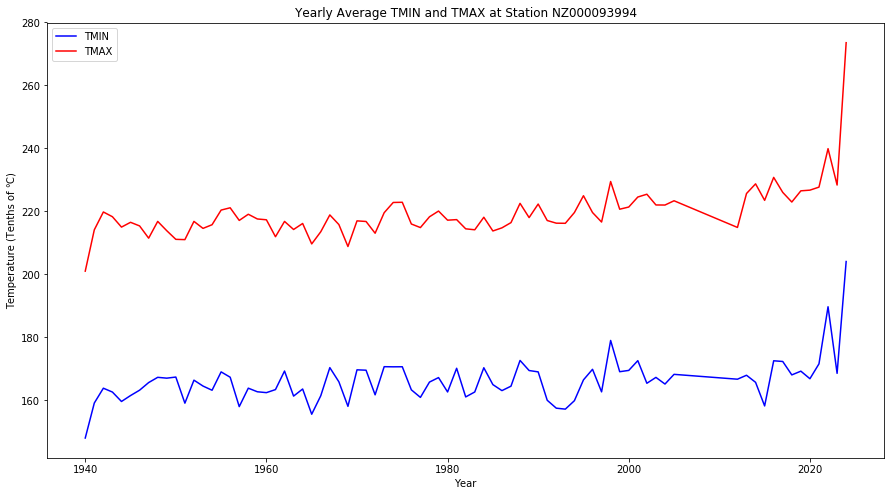

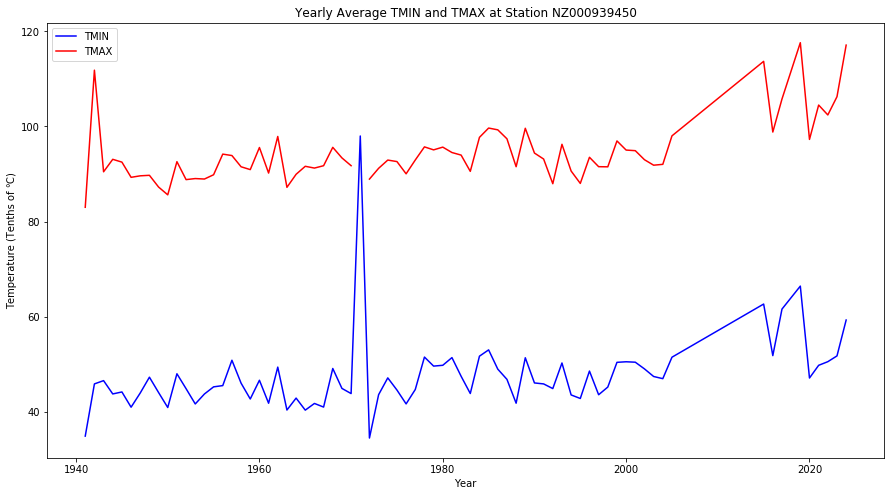

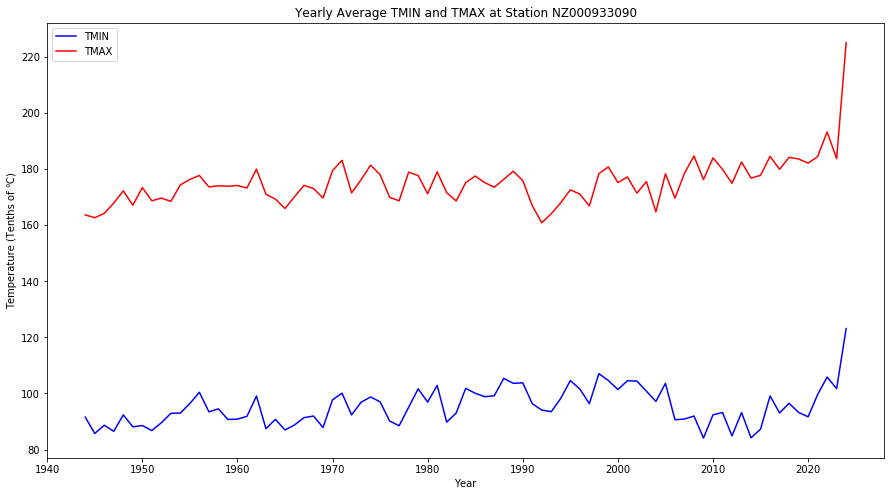

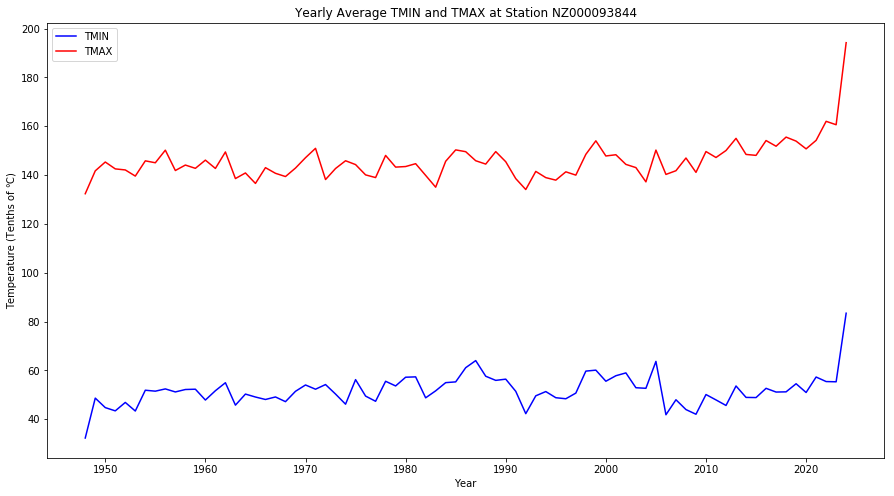

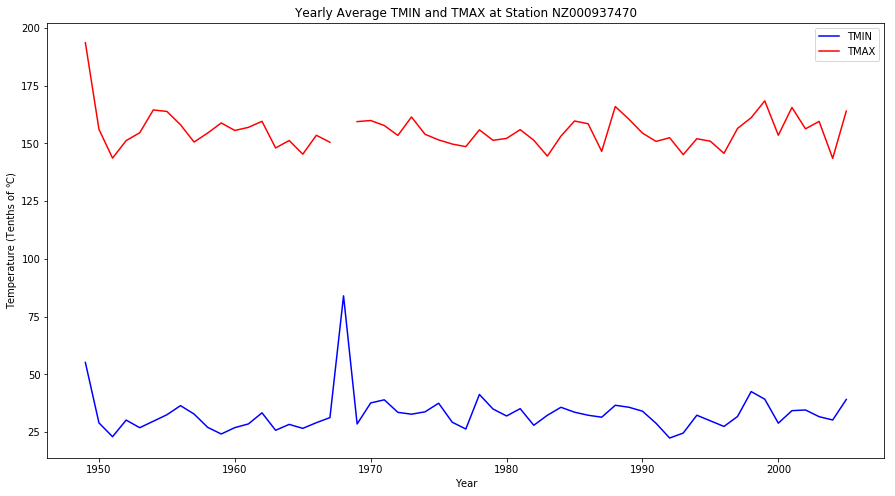

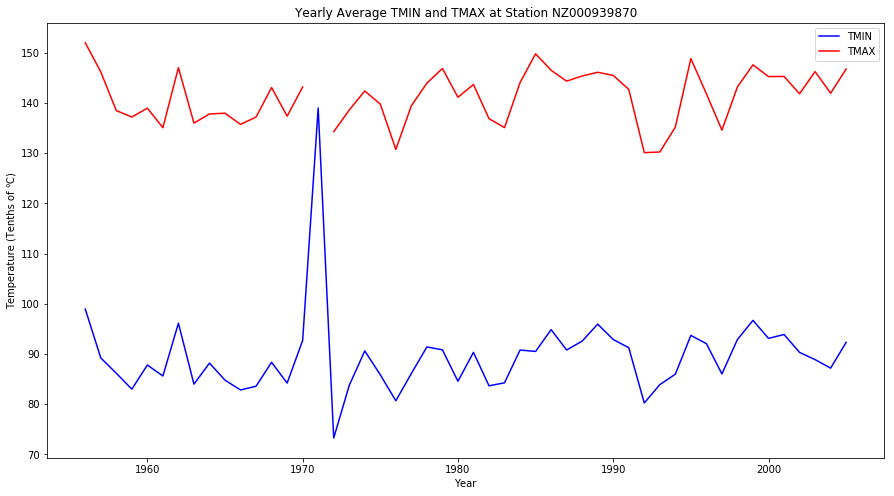

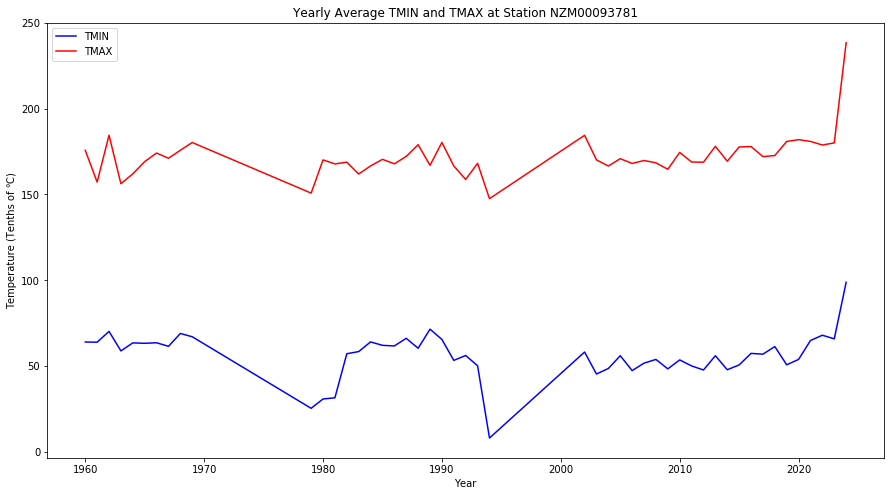

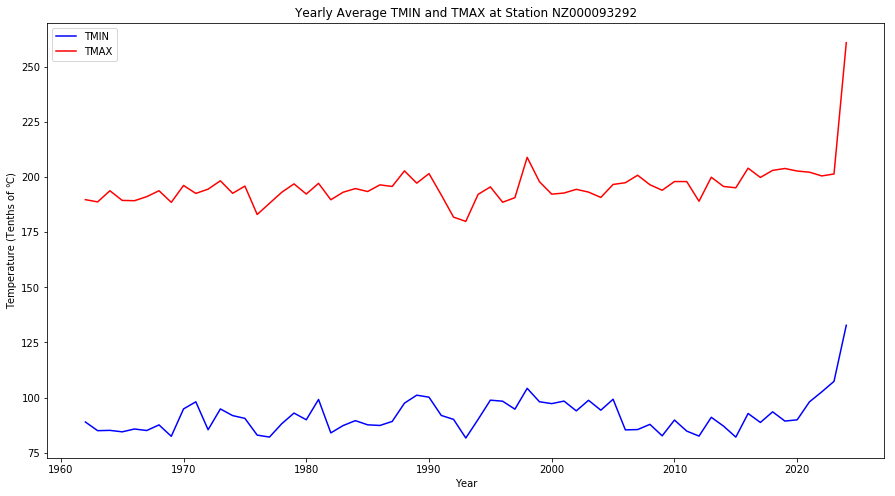

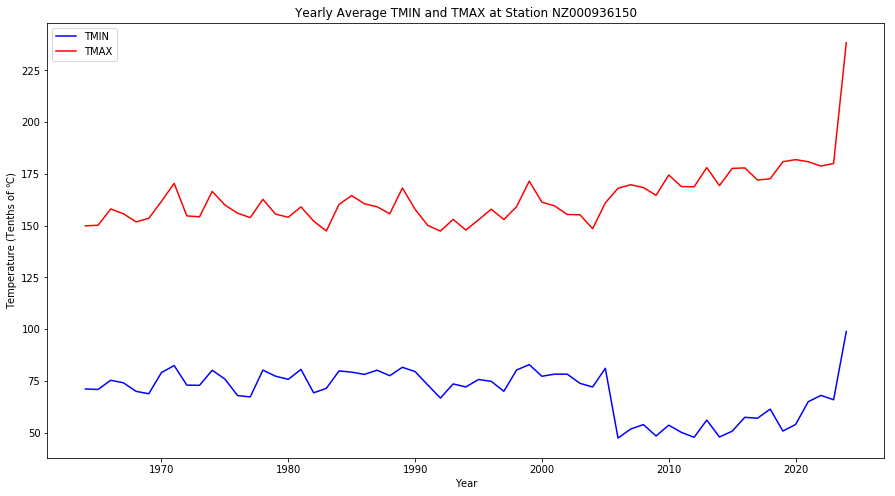

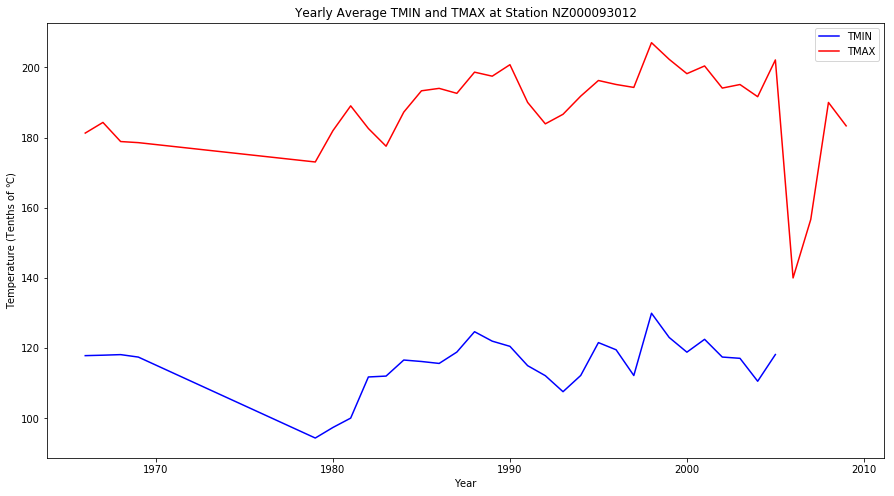

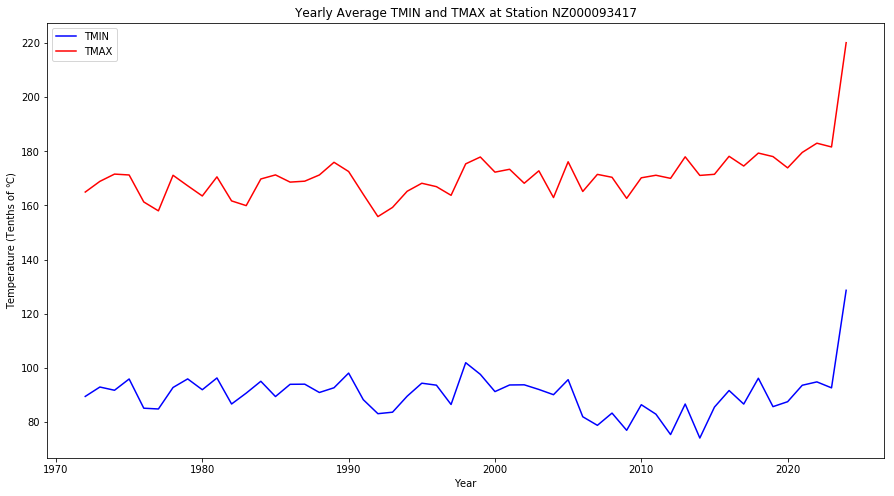

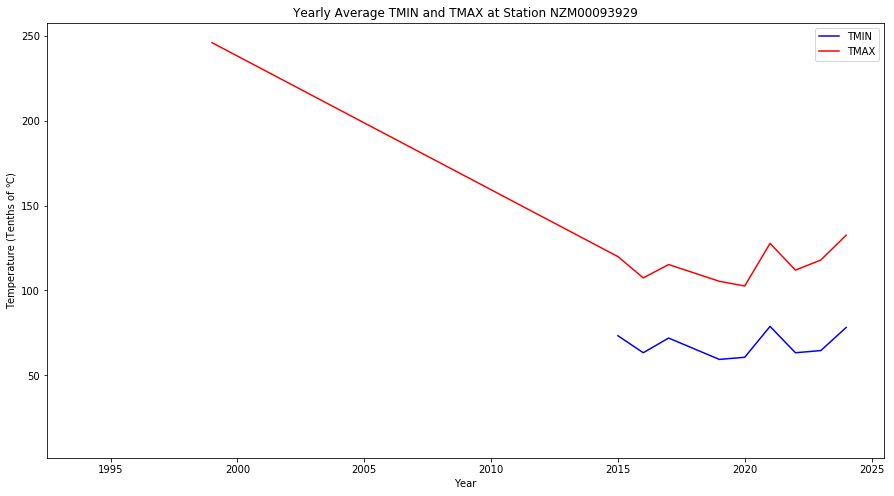

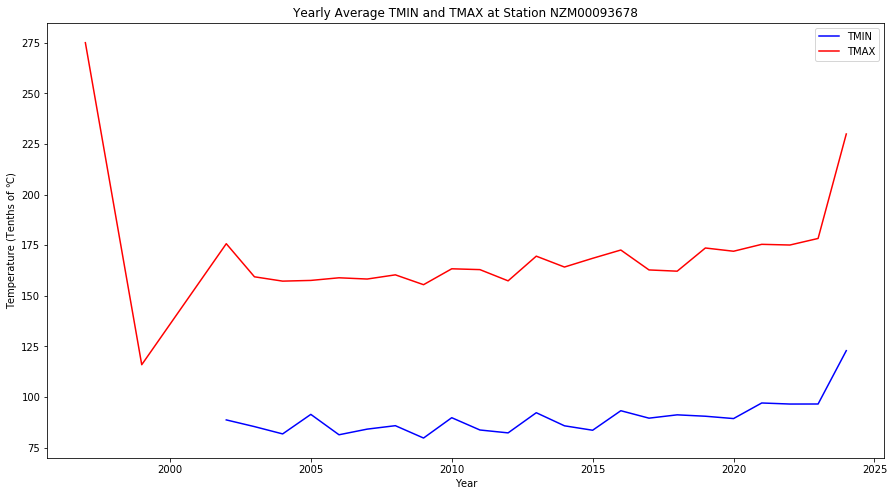

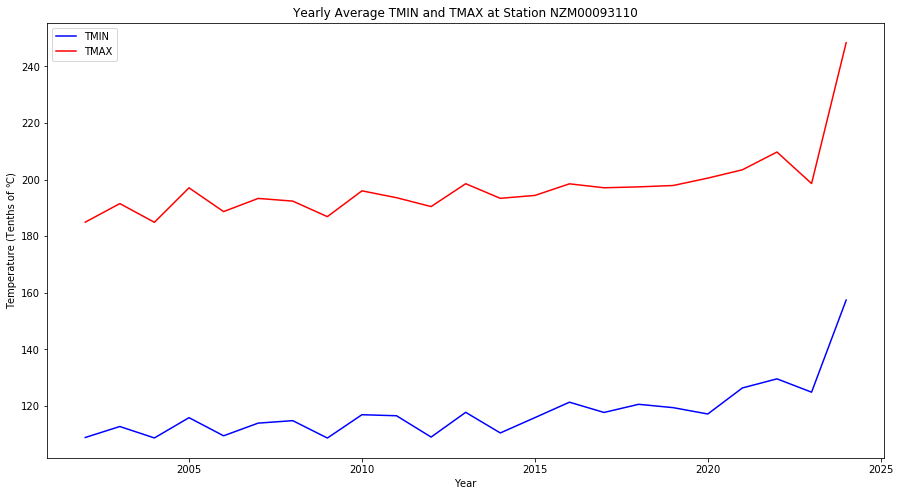

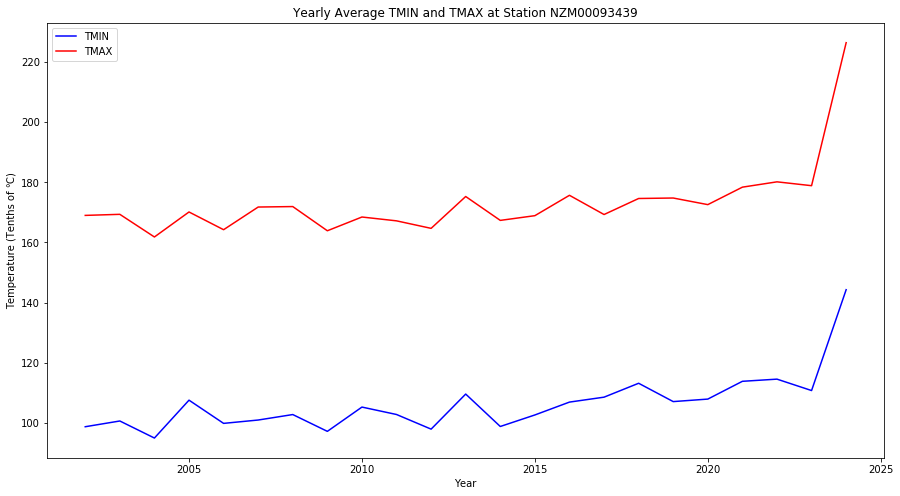

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame
tmin_tmax_nz_pd = tmin_tmax_nz.toPandas()

# Convert 'DATE' to datetime object and extract the year
tmin_tmax_nz_pd['DATE'] = pd.to_datetime(tmin_tmax_nz_pd['DATE'])
tmin_tmax_nz_pd['YEAR'] = tmin_tmax_nz_pd['DATE'].dt.year

# Create a DataFrame containing TMIN and TMAX
tmin_df = tmin_tmax_nz_pd[tmin_tmax_nz_pd['ELEMENT'] == 'TMIN'].rename(columns={'VALUE': 'TMIN'})
tmax_df = tmin_tmax_nz_pd[tmin_tmax_nz_pd['ELEMENT'] == 'TMAX'].rename(columns={'VALUE': 'TMAX'})

# Group by year and calculate average temperature
tmin_yearly_avg = tmin_df.groupby(['ID', 'YEAR']).agg({'TMIN': 'mean'}).reset_index()
tmax_yearly_avg = tmax_df.groupby(['ID', 'YEAR']).agg({'TMAX': 'mean'}).reset_index()

# Combine the two dataframes
combined_df = pd.merge(tmin_yearly_avg, tmax_yearly_avg, on=['ID', 'YEAR'], how='outer').sort_values(by='YEAR')

# Plot time series for TMIN and TMAX together for each station of NZ
for station in combined_df['ID'].unique():
    station_data = combined_df[combined_df['ID'] == station]
    plt.figure(figsize=(15, 8))
    plt.plot(station_data['YEAR'], station_data['TMIN'], label='TMIN', color='blue')
    plt.plot(station_data['YEAR'], station_data['TMAX'], label='TMAX', color='red')
    plt.title(f'Yearly Average TMIN and TMAX at Station {station}')
    plt.xlabel('Year')
    plt.ylabel('Temperature (Tenths of ℃)')
    plt.legend()
    plt.show()


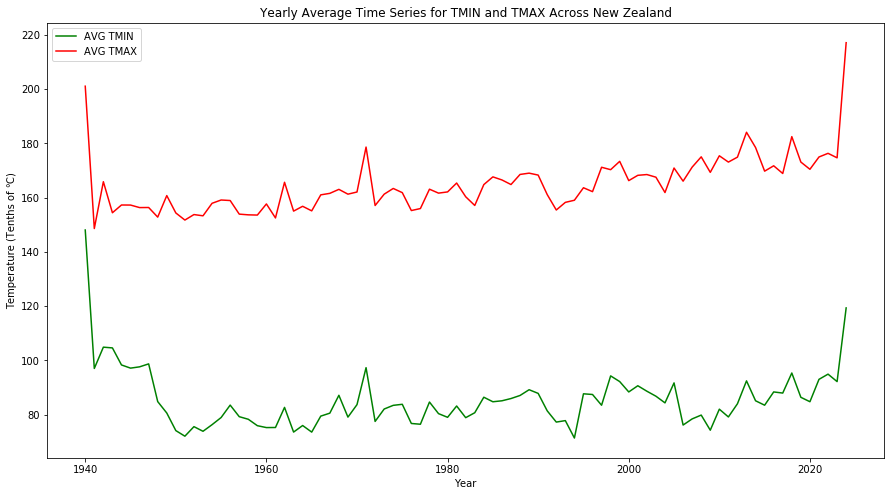

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'combined_df' contains yearly averages of TMIN and TMAX for each station
# Group by year and calculate the countrywide average for TMIN and TMAX
avg_country = combined_df.groupby('YEAR').agg({
    'TMIN': 'mean',
    'TMAX': 'mean'
}).reset_index()

plt.figure(figsize=(15, 8))
plt.plot(avg_country['YEAR'], avg_country['TMIN'], label='AVG TMIN', color='green')
plt.plot(avg_country['YEAR'], avg_country['TMAX'], label='AVG TMAX', color='red')
plt.title('Yearly Average Time Series for TMIN and TMAX Across New Zealand')
plt.xlabel('Year')
plt.ylabel('Temperature (Tenths of ℃)')
plt.legend()
plt.show()


In [ ]:
#(e)

In [42]:
show_as_html(complete_df,10)
complete_df.printSchema()

ID      DATE ELEMENT  VALUE MEASUREMENT_FLAG QUALITY_FLAG  \
0  AE000041196  20100101    TMAX  259.0             None         None   
1  AE000041196  20100101    TMIN  120.0             None         None   
2  AE000041196  20100101    TAVG  181.0                H         None   
3  AEM00041194  20100101    TMAX  250.0             None         None   
4  AEM00041194  20100101    TMIN  168.0             None         None   
5  AEM00041194  20100101    PRCP    0.0             None         None   
6  AEM00041194  20100101    TAVG  194.0                H         None   
7  AEM00041217  20100101    TMAX  250.0             None         None   
8  AEM00041217  20100101    TMIN  146.0             None         None   
9  AEM00041217  20100101    TAVG  199.0                H         None   

  SOURCE_FLAG OBSERVATION_TIME  LATITUDE  LONGITUDE            ...             \
0           S              NaT   25.3330    55.5170            ...              
1           S              NaT   25.3330    55.5170            ...              
2           S              NaT   25.3330    55.5170            ...              
3           S              NaT   25.2550    55.3640            ...              
4           S              NaT   25.2550    55.3640            ...              
5           S              NaT   25.2550    55.3640            ...              
6           S              NaT   25.2550    55.3640            ...              
7           S              NaT   24.4330    54.6510            ...              
8           S              NaT   24.4330    54.6510            ...              
9           S              NaT   24.4330    54.6510            ...              

  CODE           COUNTRY_NAME STATE_CODE STATE_NAME FIRST_ACTIVE_YEAR  \
0   AE  United Arab Emirates        None       None              1944   
1   AE  United Arab Emirates        None       None              1944   
2   AE  United Arab Emirates        None       None              1944   
3   AE  United Arab Emirates        None       None              1983   
4   AE  United Arab Emirates        None       None              1983   
5   AE  United Arab Emirates        None       None              1983   
6   AE  United Arab Emirates        None       None              1983   
7   AE  United Arab Emirates        None       None              1983   
8   AE  United Arab Emirates        None       None              1983   
9   AE  United Arab Emirates        None       None              1983   

  LAST_ACTIVE_YEAR NUM_ELEMENTS CORE_ELEMENT_CT OTHER_ELEMENT_CT  \
0             2024            4               3                1   
1             2024            4               3                1   
2             2024            4               3                1   
3             2024            4               3                1   
4             2024            4               3                1   
5             2024            4               3                1   
6             2024            4               3                1   
7             2024            4               3                1   
8             2024            4               3                1   
9             2024            4               3                1   

         COLLECTED_ELEMENTS  
0  [TMAX, TMIN, PRCP, TAVG]  
1  [TMAX, TMIN, PRCP, TAVG]  
2  [TMAX, TMIN, PRCP, TAVG]  
3  [TMAX, TMIN, PRCP, TAVG]  
4  [TMAX, TMIN, PRCP, TAVG]  
5  [TMAX, TMIN, PRCP, TAVG]  
6  [TMAX, TMIN, PRCP, TAVG]  
7  [TMAX, TMIN, PRCP, TAVG]  
8  [TMAX, TMIN, PRCP, TAVG]  
9  [TMAX, TMIN, PRCP, TAVG]  

[10 rows x 26 columns]

root
 |-- ID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: float (nullable = true)
 |-- MEASUREMENT_FLAG: string (nullable = true)
 |-- QUALITY_FLAG: string (nullable = true)
 |-- SOURCE_FLAG: string (nullable = true)
 |-- OBSERVATION_TIME: timestamp (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- GSN_FLAG: string (nullable = true)
 |-- HCN_CRN_FLAG: string (nullable = true)
 |-- WMO_ID: string (nullable = true)
 |-- COUNTRY_CODE: string (nullable = true)
 |-- CODE: string (nullable = true)
 |-- COUNTRY_NAME: string (nullable = true)
 |-- STATE_CODE: string (nullable = true)
 |-- STATE_NAME: string (nullable = true)
 |-- FIRST_ACTIVE_YEAR: string (nullable = true)
 |-- LAST_ACTIVE_YEAR: string (nullable = true)
 |-- NUM_ELEMENTS: long (nullable = true)
 |-- CORE_ELEMENT_CT: long (nullable 

In [ ]:
# Find the average rainfall step by step

In [43]:
from pyspark.sql.types import IntegerType
#Extract year from DATE and filter to rainfall data
rainfall_df = complete_df.filter(complete_df["ELEMENT"] == "PRCP")
rainfall_df.show()

+-----------+--------+-------+-----+----------------+------------+-----------+----------------+--------+---------+---------+--------------------+--------+------------+------+------------+----+--------------------+----------+----------+-----------------+----------------+------------+---------------+----------------+--------------------+
|         ID|    DATE|ELEMENT|VALUE|MEASUREMENT_FLAG|QUALITY_FLAG|SOURCE_FLAG|OBSERVATION_TIME|LATITUDE|LONGITUDE|ELEVATION|                NAME|GSN_FLAG|HCN_CRN_FLAG|WMO_ID|COUNTRY_CODE|CODE|        COUNTRY_NAME|STATE_CODE|STATE_NAME|FIRST_ACTIVE_YEAR|LAST_ACTIVE_YEAR|NUM_ELEMENTS|CORE_ELEMENT_CT|OTHER_ELEMENT_CT|  COLLECTED_ELEMENTS|
+-----------+--------+-------+-----+----------------+------------+-----------+----------------+--------+---------+---------+--------------------+--------+------------+------+------------+----+--------------------+----------+----------+-----------------+----------------+------------+---------------+----------------+--------

In [44]:
total_rainfall = (rainfall_df
                 .groupBy("Country_Name", "DATE")
                 .agg(F.sum("VALUE").alias("TOTAL_RAINFALL"),
                     F.countDistinct("ID").alias("UNIQUE_STATIONS")))
total_rainfall.show()

+------------+--------+--------------+---------------+
|Country_Name|    DATE|TOTAL_RAINFALL|UNIQUE_STATIONS|
+------------+--------+--------------+---------------+
|    Tunisia |20100102|          28.0|              5|
|    Algeria |20100228|           0.0|             52|
|    Algeria |20100402|          10.0|             54|
|    Algeria |20100505|         935.0|             54|
|    Algeria |20100518|           0.0|             54|
|    Algeria |20100614|        1000.0|             50|
|    Algeria |20100903|         588.0|             48|
|    Algeria |20101205|          10.0|             52|
|    Algeria |20101216|        3242.0|             51|
|    Algeria |20101217|        1658.0|             52|
| Antarctica |20100421|          59.0|              6|
| Antarctica |20100503|         163.0|              7|
| Antarctica |20100730|          35.0|              8|
| Antarctica |20101120|         320.0|              8|
|  Argentina |20100314|        1754.0|             25|
|  Argenti

In [45]:
avg_rainfall = total_rainfall.withColumn("AVG_RAINFALL", F.col("TOTAL_RAINFALL") / F.col("UNIQUE_STATIONS"))
avg_rainfall.show()

+------------+--------+--------------+---------------+-------------------+
|Country_Name|    DATE|TOTAL_RAINFALL|UNIQUE_STATIONS|       AVG_RAINFALL|
+------------+--------+--------------+---------------+-------------------+
|Netherlands |20110101|        2567.0|            352|  7.292613636363637|
|     Sweden |20110102|        1675.0|            725|  2.310344827586207|
|   Colombia |20110103|        1082.0|              9| 120.22222222222223|
|Netherlands |20110103|        1652.0|            352|  4.693181818181818|
|    Algeria |20110131|        1634.0|             53| 30.830188679245282|
|    Algeria |20110303|         594.0|             53|  11.20754716981132|
|    Algeria |20110315|         186.0|             53|  3.509433962264151|
|    Algeria |20110416|           8.0|             52|0.15384615384615385|
|    Algeria |20110601|        1808.0|             54|  33.48148148148148|
|    Algeria |20110807|          86.0|             51| 1.6862745098039216|
|    Algeria |20110817|  

In [46]:
avg_rainfall = avg_rainfall.withColumn("YEAR", F.year(F.to_timestamp("DATE", "yyyyMMdd")))
avg_rainfall.show()

+--------------------+--------+--------------+---------------+--------------------+----+
|        Country_Name|    DATE|TOTAL_RAINFALL|UNIQUE_STATIONS|        AVG_RAINFALL|YEAR|
+--------------------+--------+--------------+---------------+--------------------+----+
|             China  |20080103|          10.0|            198|0.050505050505050504|2008|
|            Algeria |20080106|          75.0|             51|  1.4705882352941178|2008|
|            Algeria |20080214|         721.0|             54|  13.351851851851851|2008|
|            Algeria |20080223|          81.0|             54|                 1.5|2008|
|            Algeria |20080305|         795.0|             53|                15.0|2008|
|            Algeria |20080402|        3532.0|             53|   66.64150943396227|2008|
|            Algeria |20080529|        1396.0|             54|   25.85185185185185|2008|
|            Algeria |20080718|         308.0|             54|   5.703703703703703|2008|
|            Algeria 

In [47]:
average_rainfall = (avg_rainfall
                    .groupBy("COUNTRY_NAME", "YEAR")
                    .agg(F.sum("AVG_RAINFALL").alias("AVERAGE_RAINFALL")))
average_rainfall.show()

+--------------------+----+------------------+
|        COUNTRY_NAME|YEAR|  AVERAGE_RAINFALL|
+--------------------+----+------------------+
|             Albania|1983|11308.833333333334|
|            Algeria |1942|1433.3333333333333|
|            Algeria |1963|2425.0333333333338|
|            Algeria |1968|1872.4999999999995|
|            Algeria |1987|3412.3343925805984|
|            Algeria |2005| 3122.132728313118|
|American Samoa [U...|1974|30159.666666666668|
|          Argentina |1977| 8897.641975313432|
|          Argentina |2009|19133.697777898822|
|            Armenia |1929| 4095.333333333333|
|            Armenia |1958|  4676.92793288188|
|            Armenia |1962| 4766.782016573609|
|          Australia |1873| 7974.496920868301|
|          Australia |1880| 5584.206220342928|
|          Australia |1888| 3981.369092746922|
|            Armenia |1982| 5322.456718771424|
|          Australia |1954| 7142.978973621367|
|            Austria |1948| 9736.666666666666|
|            

In [48]:
output_dir_3 = "hdfs:///user/cgo82/outputs/ghcnd/average_rainfall.csv"
average_rainfall.write.mode("overwrite").option("header", "true").option("compression", "gzip").csv(output_dir_3)

In [49]:
highest_avg_rainfall = (average_rainfall
                        .orderBy(F.desc("AVERAGE_RAINFALL"))
                        .first())

highest_country = highest_avg_rainfall["COUNTRY_NAME"]
highest_year = highest_avg_rainfall["YEAR"]
highest_rainfall = highest_avg_rainfall["AVERAGE_RAINFALL"]

print(f"The country with the highest average rainfall is {highest_country} in the year {highest_year} with an average rainfall of {highest_rainfall} mm.")

The country with the highest average rainfall is New Caledonia [France]  in the year 1999 with an average rainfall of 176744.0 mm.


In [50]:
# Filter for 2023
avg_rainfall_2023 = average_rainfall.filter(avg_rainfall["YEAR"] == 2023).toPandas()

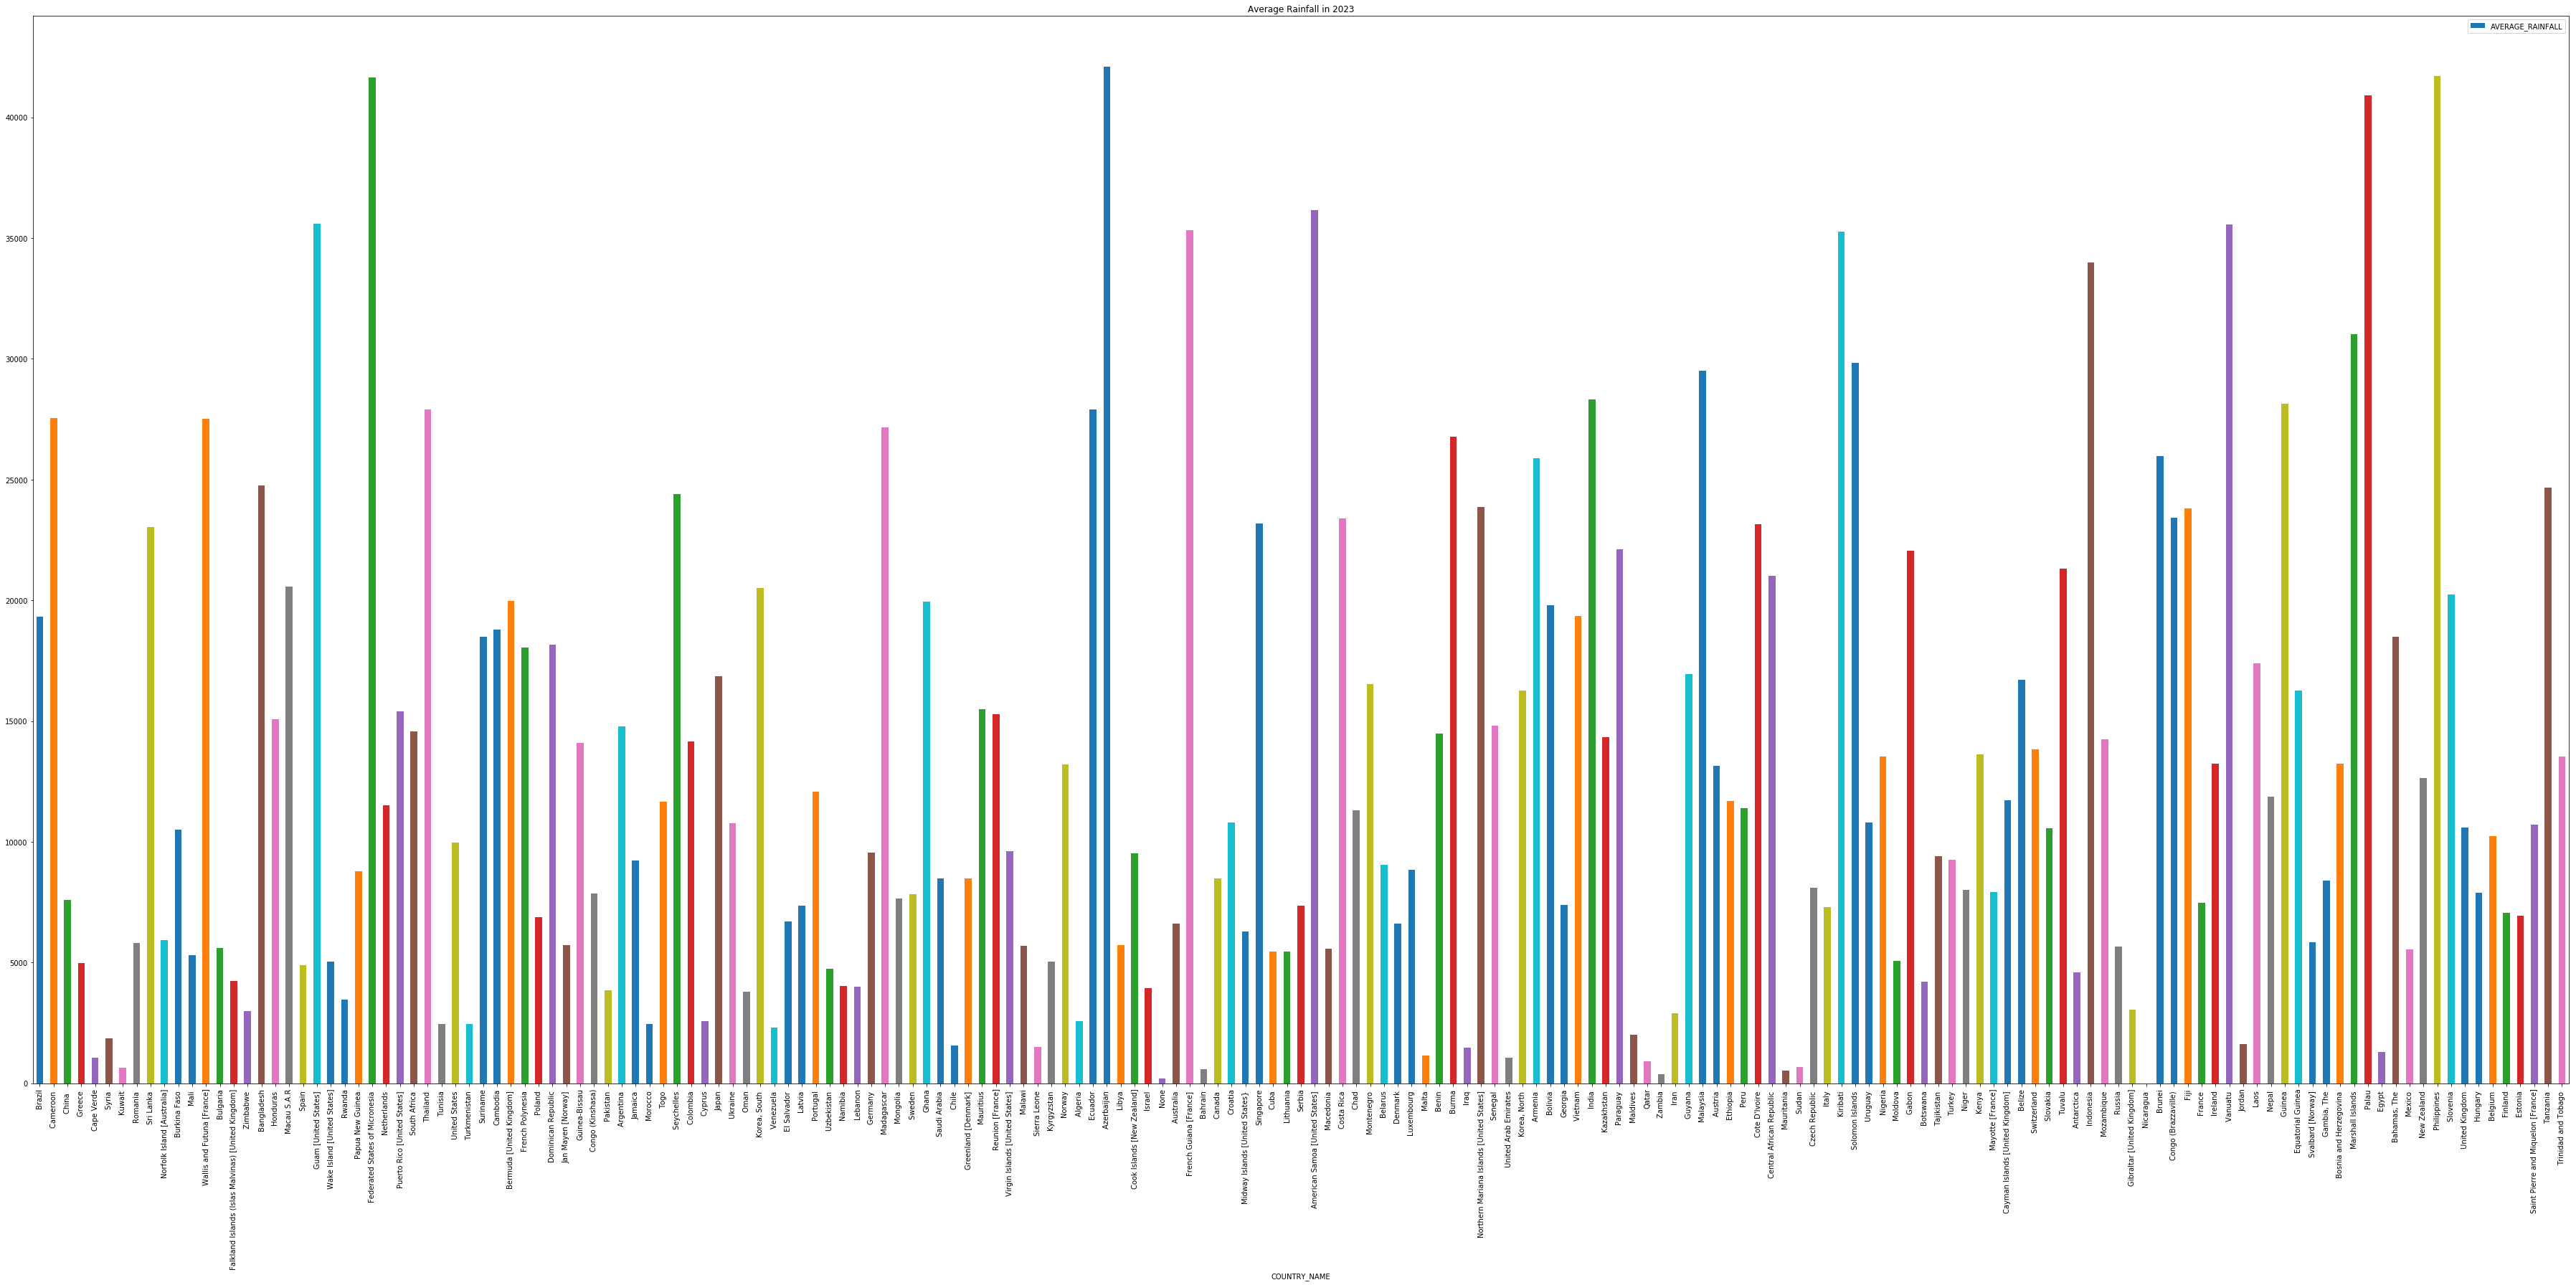

In [51]:
avg_rainfall_2023.plot(kind='bar', x='COUNTRY_NAME', y='AVERAGE_RAINFALL',
                       title='Average Rainfall in 2023', figsize=(50, 25))  


# Show the plot
plt.tight_layout() 
plt.show()

In [52]:
import plotly.express as px

In [53]:
fig = px.choropleth(avg_rainfall_2023,
                    locations='COUNTRY_NAME',  
                    locationmode='country names',  
                    color='AVERAGE_RAINFALL',  
                    color_continuous_scale=px.colors.sequential.Plasma,  
                    )

fig.update_layout(
    title={
        'text': "Average Rainfall by Country in 2023",
        'y':0.88,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    width=1000,  
    height=600   
)


fig.show()

In [54]:
stop_spark()